In [ ]:
# Welcome to my Personal Chess Analysis Data Science Project. The goal of this project is to find patterns in my games
# and find weaknesses in my game, such as chess openings I struggle against. This is Part 1 of my project, and in Part 
# I am exploring a dataset of games I played on chess.com. I want to be able to build my own dataset using chess pgn
# data. I used Part 1 of this project as a way to sharpen my data cleaning skills as I am working with a messy and
# unfamiliar dataset. 

# To get my data, I used Reddit User johndoe3991's program to download all of my pgns. The below code block is a link 
# to the program and my personal modifications to it.


In [ ]:
# Source: https://www.reddit.com/r/chess/comments/9ifkaq/how_i_downloaded_all_my_chesscom_games_using/
# chess.com API -> https://www.chess.com/news/view/published-data-api
# The API has been used to download monthly archives for a user using a Python3 program.
# This program works as of 24/09/2018

# import urllib
# import urllib.request


# username = "335394862" # change 
# baseUrl = "https://api.chess.com/pub/player/" + username + "/games/"
# archivesUrl = baseUrl + "archives"

# #read the archives url and store in a list
# f = urllib.request.urlopen(archivesUrl)
# archives = f.read().decode("utf-8")
# archives = archives.replace("{\"archives\":[\"", "\",\"")
# archivesList = archives.split("\",\"" + baseUrl)
# archivesList[len(archivesList)-1] = archivesList[len(archivesList)-1].rstrip("\"]}")

# #download all the archives
# for i in range(len(archivesList)-1):
#     url = baseUrl + archivesList[i+1] + "/pgn"
#     filename = archivesList[i+1].replace("/", "-")
#     urllib.request.urlretrieve(url, "/Users/hairanliang/Documents/Chess.com/MyGames" + filename + ".pgn") #change
#     print(filename + ".pgn has been downloaded.")
# print ("All files have been downloaded.")

In [ ]:
# Miscellaneous Notes During Data Cleaning:
# I noticed that there were games where no move was played before a player resigned, and these games for some reason 
# led to the dataframe to be offset and thus the columns would be offset. To solve this, I manually searched "Current 
# Position" which helped me manually delete all these games from the pgn (in total 16) as these games had a unique 
# value for their "Current Position" value

In [ ]:
# Import the chess modules to read pgns in python
import chess
import chess.pgn 
import cv2
import os

chessGamesList = [] # List that will hold the chess game information

# load_pgns_from_folder("/Users/hairanliang/Documents/Chess.com/MyGames")
pgn = open('/Users/hairanliang/Documents/Chess.com/MyGames/allPgns.txt', 'r')

In [ ]:
for i in pgn:
    chessGamesList.append(i) # Getting each line of the pgn document one by one
    
chessGamesList

In [ ]:
chessGamesList[22] # In index 22 of the list, it holds the game notation for game 1.  

In [ ]:
# Exploratory Data Analysis

# Look at basic things like my winrate as white and black. Then look at average number of moves per game, per win, 
# per loss, per draw, as white, as black, etc.
# Then, I can start playing with date-time data by looking at which days of the week I play better, which time of day,
# etc

In [ ]:
# First, I have to create my DataFrame. I will use a Pandas Dataframe for this

# Using list comprehension to create a 2d list, and then converting it into a pandas DataFrame later
twoDArray = [[''] * 25 for i in range(5000)]

# Filling up my 2d list with the chessGamesList
counter = 0
for row in range(0, len(chessGamesList)):
    holder = row # Have to use the holder since the row value in chessGamesList is getting rewritten in the line below
    row = row % 25 # Every 25 indices in chessGamesList, it moves on to the next game in the dataset
    twoDArray[counter][row] = chessGamesList[holder];
    if row == 0: # Once reaching the next game, have to move to the row below to input next values 
        counter = counter + 1
    row += 1




In [ ]:
twoDArray[3800] # This holds all the information from the initial dataset for the longest game I've played (120 moves)

In [ ]:
# Building my dataframe using twoDArray. Column names are based on the name convention from the dataset

import pandas as pd
df1 = pd.DataFrame(data = twoDArray, columns = ['Event', 'Site', 'Date', 'Round', 'White', 'Black', 'Result', 'Position', 'Timezone', 
                              'ECO', 'ECOUrl', 'UTCDate', 'UTCTime', 'WhiteElo', 'BlackElo', 'TimeControl', 'Termination', 'StartTime',
                              'EndDate', 'EndTime', 'Link', 'Null1', 'Moves', 'Null2', 'Null3'])
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
df1



In [ ]:
# Now, I will get rid of all Null columns. There is also a problem with the first row, but I will fix that later

df2 = df1.drop(columns = ['Null1', 'Null2', 'Null3'])

In [ ]:
df2.head(25)

In [ ]:
# Now, drop all rows with NaN values. First, I will convert all the empty strings

import numpy as np
df2.replace('', np.nan, inplace=True)
df2 = df2.drop([0]).reset_index(drop=True)
df2.iat[4445, 0] = '[Event "Live Chess"]\n' # Small edits to clean up the dataset 

In [ ]:
df2

In [ ]:
df3 = df2.dropna(axis='rows') # Drop all rows that have any null values in them

In [ ]:
df3 # Final DataFrame that has all the information and no NaN values

In [ ]:
terminationSeries = pd.Series(df3['Termination'].values) # Building a Series with the Termination column
# The termination column tells who wins, or if it was a draw.

In [ ]:
terminationSeries

In [ ]:
terminationBool = terminationSeries.str.contains(pat = '335394862') # terminationBool is essentially my "winBool", so
# it will hold a logical array of the games I won. This is based on if my username is in the Termination value.

In [ ]:
terminationBool

In [ ]:
# To get losses, it is more difficult, so what I'll do is check for the draws and then the remaining ones must be losses.

drawBool = terminationSeries.str.contains(pat = 'Game drawn')
drawBool

In [ ]:
lossBool = ~drawBool & ~terminationBool # Losses are when its neither a draw nor a win
lossBool

In [ ]:
winRate = sum(bool(x) for x in terminationBool) / len(terminationBool) 
winRate # This is my overall winrate. Technically, it's not my true "winrate" because I haven't factored in draws

In [ ]:
drawRate = sum(bool(x) for x in drawBool) / len(terminationBool)
drawRate

In [ ]:
lossRate = sum(bool(x) for x in lossBool) / len(terminationBool)
lossRate

In [ ]:
# Now, let's find my winrate as white and as black

# Boolean array for games where I am white

whiteSeries = pd.Series(df3['White'].values) # Using the white column of the Dataframe
whiteBool = whiteSeries.str.contains(pat = '335394862') # Getting a boolean list for where I played white



In [ ]:
whiteBool # In the first 4 games, I played white, then I played black twice... etc

In [ ]:
whiteTermination = terminationSeries[whiteBool] # Using the boolean list to create a termination series with only my 
# games as white

In [ ]:
whiteTermination # These are the termination values for only the games where I played white

In [ ]:
whiteTerminationBool = whiteTermination.str.contains(pat = '335394862') # Only the games where I won as white
whiteWinrate = sum(bool(x) for x in whiteTerminationBool) / len(whiteTerminationBool) 
# Number of games I won as white divided by number of games I played as white 
whiteWinrate

In [ ]:
# Now, I repeat this for the black games

blackSeries = pd.Series(df3['Black'].values) 
blackBool = blackSeries.str.contains(pat = '335394862')

blackTermination = terminationSeries[blackBool] 

blackTerminationBool = blackTermination.str.contains(pat = '335394862') # Only the white games where I won (white game = I'm playing white)
blackWinrate = sum(bool(x) for x in blackTerminationBool) / len(blackTerminationBool) 
blackWinrate # Unsurprisingly, my winrate as white is higher than as black: white has an inherent advantage

In [ ]:
blackTerminationBool

In [ ]:
# Now I want to find out if I have a higher win-rate when I play black against 1. e4 or 1. d4 
# My gut says that I do much better against e4

movesSeries = pd.Series(df3['Moves'].values) 

e4Bool = movesSeries.str.contains(pat = '1\. e4')
e4Bool

In [ ]:
e4Termination = terminationSeries[e4Bool] # The termination column for games that started as 1. e4
e4Termination

In [ ]:
e4TerminationBool = e4Termination.str.contains(pat = '335394862')
e4TerminationBool

In [ ]:
blackTerminationBool

In [ ]:
e4BlackTerminationBool = e4TerminationBool & blackTerminationBool
e4BlackTerminationBool # The only true is if both it was an e4 game AND I won the game as black
# (True + True = True and anything else is False)

In [ ]:
blackAndE4 = e4Bool & blackBool
blackAndE4


In [ ]:
blackAndE4WR = sum(bool(x) for x in e4BlackTerminationBool) / sum(bool(x) for x in blackAndE4) 
blackAndE4WR # My winrate as black against e4 is 0.51, so I do pretty well against 1.e4

In [ ]:
d4Bool = movesSeries.str.contains(pat = '1\. d4')
d4Termination = terminationSeries[d4Bool]
d4TerminationBool = d4Termination.str.contains(pat = '335394862')
d4BlackTerminationBool = d4TerminationBool & blackTerminationBool
blackAndD4 = d4Bool & blackBool
blackAndD4WR = sum(bool(x) for x in d4BlackTerminationBool) / sum(bool(x) for x in blackAndD4) 
blackAndD4WR

# As I expected, my play against d4 is significantly worse: I have a 47.6% winrate as black compared to 51.3% against
# e4. I'll now check two less popular but possible moves 1.c4 and 1.Nf3

In [ ]:
c4Bool = movesSeries.str.contains(pat = '1\. c4')
c4Termination = terminationSeries[c4Bool]
c4TerminationBool = c4Termination.str.contains(pat = '335394862')
c4BlackTerminationBool = c4TerminationBool & blackTerminationBool
blackAndC4 = c4Bool & blackBool
blackAndC4WR = sum(bool(x) for x in c4BlackTerminationBool) / sum(bool(x) for x in blackAndC4) 
blackAndC4WR

# Surprisingly, I perform HORRIBLY against c4. Maybe it's time for me to freshen up on my c4 opening theory

In [ ]:
nf3Bool = movesSeries.str.contains(pat = '1\. Nf3')
nf3Termination = terminationSeries[nf3Bool]
nf3TerminationBool = nf3Termination.str.contains(pat = '335394862')
nf3BlackTerminationBool = nf3TerminationBool & blackTerminationBool
blackAndNf3 = nf3Bool & blackBool
blackAndNf3WR = sum(bool(x) for x in nf3BlackTerminationBool) / sum(bool(x) for x in blackAndNf3) 
blackAndNf3WR

In [ ]:
# Now, I want to find out how I do against black openings when I play 1.e4 as white. My hunch is that I perform best 
# against the French, then the Caro Kann, then Sicilian, then 1... e5. Let's find out!

# I have a bool that checks for 1.e4, and now I need bools that check for 1... e5, 1... c5, 1... c6, 1... e6

e5Bool = movesSeries.str.contains(pat = ' 1\.\.\. e5') 
e5Termination = terminationSeries[e5Bool]
e5TerminationBool = e5Termination.str.contains(pat = '335394862')
e4E5WhiteTerminationBool = e5TerminationBool & whiteTerminationBool & e4TerminationBool
whiteAndE4E5 = e5Bool & whiteBool & e4Bool
whiteAndE4E5WR = sum(bool(x) for x in e4E5WhiteTerminationBool) / sum(bool(x) for x in whiteAndE4E5) 
whiteAndE4E5WR

In [ ]:
sum(bool(x) for x in e4E5WhiteTerminationBool)


In [ ]:
c5Bool = movesSeries.str.contains(pat = ' 1\.\.\. c5')
c5Termination = terminationSeries[c5Bool]
c5TerminationBool = c5Termination.str.contains(pat = '335394862')
e4C5WhiteTerminationBool = c5TerminationBool & whiteTerminationBool & e4TerminationBool
whiteAndE4C5 = c5Bool & whiteBool & e4Bool
whiteAndE4C5WR = sum(bool(x) for x in e4C5WhiteTerminationBool) / sum(bool(x) for x in whiteAndE4C5) 
whiteAndE4C5WR

In [ ]:
c6Bool = movesSeries.str.contains(pat = '1\.\.\. c6')
c6Termination = terminationSeries[c6Bool]
c6TerminationBool = c6Termination.str.contains(pat = '335394862')
e4C6WhiteTerminationBool = c6TerminationBool & whiteTerminationBool & e4TerminationBool
whiteAndE4C6 = c6Bool & whiteBool & e4Bool
whiteAndE4C6WR = sum(bool(x) for x in e4C6WhiteTerminationBool) / sum(bool(x) for x in whiteAndE4C6) 
whiteAndE4C6WR

In [ ]:
e6Bool = movesSeries.str.contains(pat = '1\.\.\. e6')
e6Termination = terminationSeries[e6Bool]
e6TerminationBool = e6Termination.str.contains(pat = '335394862')
e4E6WhiteTerminationBool = e6TerminationBool & whiteTerminationBool & e4TerminationBool
whiteAndE4E6 = e6Bool & whiteBool & e4Bool
whiteAndE4E6WR = sum(bool(x) for x in e4E6WhiteTerminationBool) / sum(bool(x) for x in whiteAndE4E6) 
whiteAndE4E6WR

# Surprisingly, I performed worse comparatively against the French (1.e4 1...e6)


In [ ]:
# Now I look at games that pass 40 moves (and to check for this I check for the moves including "40...") And, by moves
# I mean "full" moves, so both white and black made a move. Thus, a game ending with white making the 31st move would
# be counted as a 30-move game by my logic

past40Bool = movesSeries.str.contains(pat = ' 40\.\.\.')
past40Termination = terminationSeries[past40Bool]
past40TerminationBool = past40Termination.str.contains(pat = '335394862')
past40WR = sum(bool(x) for x in past40TerminationBool) / sum(bool(x) for x in past40Bool) 
past40WR # My winrate as games go past 40 moves is 45.6%

# While I was doing this analysis, I decided to see what the longest game I've ever played was, and I found this was 
# when pat = "120...", so the longest game I've played online on chess.com is 120 moves. This gave me the idea to make
# a line plot that tracks the winrate as the number of moves in a game increases. Right now, when I do the winrate
# for say 25 moves, it will include games that have AT LEAST 25 moves, not strictly 25 moves. However, I think this 
# will still be a useful visualization because I can see if I perform worse as games go on.

In [ ]:
# Initializing the arrays I will use to hold information about number of games that reach x moves (x is variable),
# number of games I won that reach x moves, and my winrate after a game reaches x moves.
pastMoveTotalArray = []
pastMoveWinsArray = []
pastMoveWRArray = []

for moveNumber in range(1, 121):
    pastMoveBool = movesSeries.str.contains(pat = f"{moveNumber}\.\.") # Logical array of games reaching x moves
    pastMoveTermination = terminationSeries[pastMoveBool] # Termination series of games reaching x moves that I won
    pastMoveTerminationBool = pastMoveTermination.str.contains(pat = '335394862') # Logical array of games I won reaching x moves
    try:
        pastMoveTotalGames = sum(bool(x) for x in pastMoveBool)
        pastMoveWins = sum(bool(x) for x in pastMoveTerminationBool)
        pastMoveWR = pastMoveWins / pastMoveTotalGames 
    except ZeroDivisionError: 
        pastMoveWR = 0
    # Add numbers to array here that can then be used for line plot.
    pastMoveTotalArray.append(pastMoveTotalGames)
    pastMoveWinsArray.append(pastMoveWinsArray)
    pastMoveWRArray.append(pastMoveWR)
print(pastMoveWRArray)

In [ ]:
pastMoveTotalArray

<AxesSubplot:>

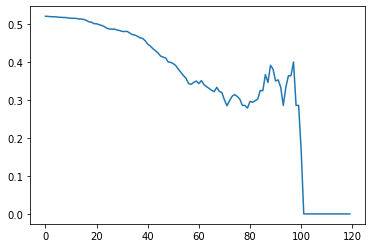

In [184]:
import seaborn as sb

# Make a line plot of how the winrate changes as number of moves changes 

sb.lineplot(data=pastMoveWRArray)

# There is a large drop in winrate, so I wanted to investigate why this occurred. Was there a case of not enough games 
# after a certain number of moves, causing a much lower winrate? 

In [ ]:
print(pastMoveTotalArray) 

In [ ]:
pastMoveWRArray[20] # I maintained a above-50 winrate for games that were 21 moves or less. 

In [ ]:
pastMoveWRArray[21] # Once games were 22 moves or more, I started to have a sub-50 winrate. HOWEVER, it's important
# to understand what this really means. This means that in the other 50% of the time, I either lose or DRAW. Because 
# of the existence of drawn games, it is likely that if I am winning 49.8 % of the time, I am probably winning more
# often than losing as a certain percentage of games will be draws

In [ ]:
# Now, I want to find things like average number of moves in won games and in lost games. 

In [ ]:
drawrate = sum(bool(x) for x in drawBool) / len(terminationBool)
drawrate

In [ ]:
# To get the number of moves in a game, I can start backwards from 120 moves, and if it fulfills it, then I note
# its move count and move on to the next game. Then, after I have this huge array, I can add it as a 
# column to my main dataframe 

movesSeries

In [ ]:
import re
movesNumberArray = []
for game in movesSeries:
    for i in range(120, 0, -1):
        if re.search(f"{i}\.\.", game): # Using regex to search for a move number within the game
            movesNumberArray.append(i)
            break
        if i == 1: # This is an edge case where the game ends after white plays their first move (no case of 1...)
            movesNumberArray.append(0) # In this case there was 0 "full moves" played in this "game" 
            
print(movesNumberArray)       
            

In [ ]:
len(movesNumberArray) # Ensuring there are the right number of rows to match the rows of our dataframe

In [ ]:
df3['Number of Moves'] = movesNumberArray # Adding the move number column to the dataframe
df3

In [ ]:
# Finding average number of moves in won games (terminationBool is essentially winBool)

terminationBool



In [ ]:
numberMovesSeries = pd.Series(df3['Number of Moves'].values)

In [ ]:
numberMovesTerminationSeries = numberMovesSeries[terminationBool] # These are all the move counts of the games I won

numberMovesTerminationSeries # First column is index of game and second column is number of moves in the game




In [ ]:
# Now, to find the average move count I just take the sum divided by the length of the series

avgMoveCountForWins = sum(numberMovesTerminationSeries) / len(numberMovesTerminationSeries)
avgMoveCountForWins # It takes me around 36 moves on average to win

In [ ]:
numberMovesLossSeries = numberMovesSeries[lossBool] # These are all the move counts of the games I won

numberMovesLossSeries

In [ ]:
avgMoveCountForLosses = sum(numberMovesLossSeries) / len(numberMovesLossSeries)
avgMoveCountForLosses # On average, I lose in around 39 moves. This could mean I generally lose in longer games

In [ ]:
numberMovesDrawSeries = numberMovesSeries[drawBool] # These are all the move counts of the games I drew

numberMovesDrawSeries

In [ ]:
avgMoveCountForDraws = sum(numberMovesDrawSeries) / len(numberMovesDrawSeries)
avgMoveCountForDraws # On average, my drawn games take 52 moves. This makes sense because the closer the game is,
# the more likely it'll turn into a draw. Games lasting longer are typically closer.

In [ ]:
# This concludes Part 1 of my Personal Chess Analysis Project. I performed an EDA on my games, where I played around
# with a messy dataset and converted it into a usable dataframe. I found out interesting weaknesses in my play, such 
# as how I struggle against 1.c4 the most as black and 1... e6 as white

# In Part 2 of my project, I hope to incorporate machine learning by predicting the outcome of games based on the use 
# of central squares and rating differential. Rating differential is a topic I find very interesting as it varies 
# between people: some people perform better against stronger opponents than their rating would suggest, and some 
# play worse against weaker opponents than their rating would suggest. I hope to create a model that would be trained
# on my dataset of games to see if common principles like controlling the center and things like rating differential
# play a large role in determining who wins the game.